In [3]:
import pandas as pd

df = pd.read_csv('../data/spanish_corpus_features_v3.csv')

In [4]:
df.head()

,text,n_sents,n_words,avg_words_sents,word_size,unique_words,ttr,mltd,propn_ratio,noun_ratio,adp_ratio,det_ratio,punct_ratio,pron_ratio,verb_ratio,adv_ratio,label
0,sofía castro y alejandro peña pretelini: una i...,8,252,31.500000,4.190476,34.920635,50.000000,58.600559,15.079365,15.079365,13.888889,11.507937,9.523810,5.555556,6.349206,3.174603,1
1,un paso más cerca de hacer los exámenes 'onlin...,9,486,54.000000,4.255144,32.716049,44.238683,41.283136,16.666667,15.226337,12.345679,11.111111,18.930041,1.234568,3.292181,1.646091,1
2,esto es lo que los científicos realmente piens...,31,980,31.612903,4.815306,26.020408,38.571429,80.551467,4.795918,17.857143,13.979592,12.755102,11.836735,2.551020,10.306122,4.693878,1
3,inicia impresión de boletas para elección pres...,11,369,33.545455,4.728997,22.764228,37.398374,50.995314,4.065041,22.493225,18.157182,15.176152,11.111111,2.710027,7.317073,0.271003,1
4,a *number* día del mundial\nfifa.com sigue la ...,5,130,26.000000,4.461538,48.461538,60.000000,47.081602,14.615385,14.615385,17.692308,13.846154,9.230769,3.076923,4.615385,1.538462,1


In [6]:
df.shape

(971, 17)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 17 columns):
text               971 non-null object
n_sents            971 non-null int64
n_words            971 non-null int64
avg_words_sents    971 non-null float64
word_size          971 non-null float64
unique_words       971 non-null float64
ttr                971 non-null float64
mltd               971 non-null float64
propn_ratio        971 non-null float64
noun_ratio         971 non-null float64
adp_ratio          971 non-null float64
det_ratio          971 non-null float64
punct_ratio        971 non-null float64
pron_ratio         971 non-null float64
verb_ratio         971 non-null float64
adv_ratio          971 non-null float64
label              971 non-null int64
dtypes: float64(13), int64(3), object(1)
memory usage: 129.1+ KB


In [9]:
df.columns

Index(['text', 'n_sents', 'n_words', 'avg_words_sents', 'word_size',
       'unique_words', 'ttr', 'mltd', 'propn_ratio', 'noun_ratio', 'adp_ratio',
       'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 'adv_ratio',
       'label'],
      dtype='object')

/home/pipe11/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Testing AUC: 0.889155


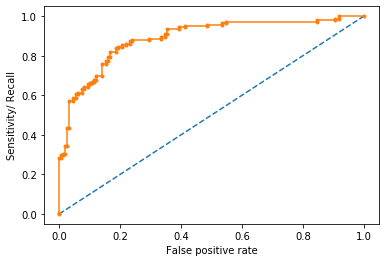

Logloss: 6.74
Accuracy: 80.48


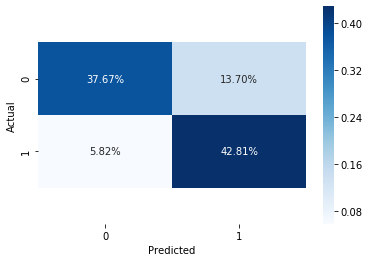

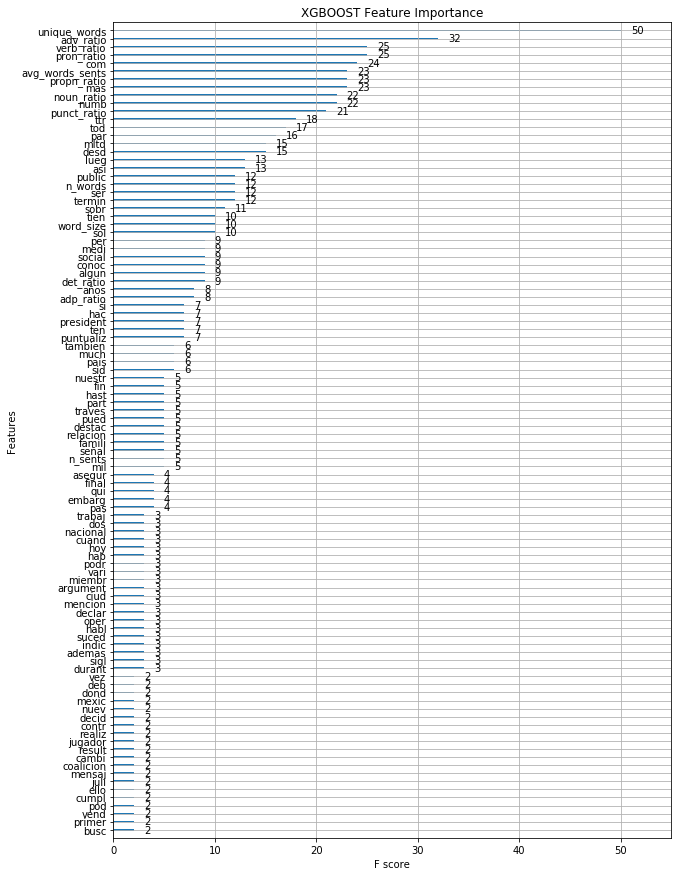

In [10]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords  
from nltk import word_tokenize  
from nltk.data import load  
from nltk.stem import SnowballStemmer  
from string import punctuation

from scipy import stats
from scipy.sparse import hstack, csr_matrix
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, classification_report, log_loss

df = pd.read_csv('../data/spanish_corpus_features_v3.csv')
y = df['label']

####### TFIDF Transformation to text ########

#Stopword list to use
spanish_stopwords = stopwords.words('spanish')

#Spanish stemmer:
stemmer = SnowballStemmer('spanish')

def stem_tokens(tokens, stemmer):  
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

#Punctuation to remove
non_words = list(punctuation)

#Adding spanish punctuation
non_words.extend(['¿', '¡'])  
non_words.extend(map(str,range(10)))

def tokenize(text):  
    #Remove punctuation
    text = ''.join([c for c in text if c not in non_words])
    #Tokenize
    tokens =  word_tokenize(text)

    #Stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems


tfidf_vectorizer = TfidfVectorizer(  
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = spanish_stopwords)

text_vectorized = tfidf_vectorizer.fit_transform(df['text'])

tfvocab = tfidf_vectorizer.get_feature_names()


########### Combine features & train, test split ########### 

numerical_features = ['n_sents', 'n_words', 'avg_words_sents', 'word_size', 'unique_words', 'ttr', 'mltd', 'propn_ratio', 
                      'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 'adv_ratio']

X = hstack([csr_matrix(df[numerical_features].values), text_vectorized[0:]])
tfvocab = df[numerical_features].columns.tolist() + tfvocab

# Calculating level of imbalance for modelling
imbalance_weight = y.value_counts(normalize = True)[0] / y.value_counts(normalize = True)[1]

# Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)


########### XGB CLassifier ########### 

xgb_model = XGBClassifier(eval_metric = 'auc', objective = 'binary:logistic', nthread = 1, seed = 43, 
                    scale_pos_weight = imbalance_weight)

xgb_params = {'alpha': 0, 
              'colsample_bytree': 0.75, 
              'lambda': 1, 
              'learning_rate': 0.01,
              'max_depth': 3, 
              'min_child_weight': 1, 
              'n_estimators': 1000, 
              'subsample': 0.6}

xgb_model.fit(X_train, y_train)


########### Predictions and results ###########

# predictions
y_pred = xgb_model.predict(X_test)
probs = xgb_model.predict_proba(X_test)
probs = probs[:, 1]

# testing AUC
auc = roc_auc_score(y_test, probs)
print('Testing AUC: %f' % auc)

# roc curve calculation
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)

# plot the limits for no skill
plt.plot([0, 1], [0, 1], linestyle = '--')

# plot the roc curve

plt.plot(false_positive_rate, true_positive_rate, marker = '.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
plt.show();

# accuracy score
print('Logloss: %.2f' % (log_loss(y_test, y_pred)))
print('Accuracy: %.2f' % (xgb_model.score(X_test, y_test) * 100))

# confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, labels = [0, 1])
ax = sns.heatmap(cf_matrix / np.sum(cf_matrix), annot = True, fmt = '.2%', cmap = 'Blues')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show();


########### Feature importance ###########

dict_features = dict(enumerate(tfvocab))

# feature importance with default names

f, ax = plt.subplots(figsize = [10, 15])
axsub = xgb.plot_importance(xgb_model, max_num_features = 100, ax = ax)

# get the original names back
Text_yticklabels = list(axsub.get_yticklabels())
dict_features = dict(enumerate(tfvocab))
lst_yticklabels = [Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]
lst_yticklabels = [dict_features[int(i)] for i in lst_yticklabels]

# feature importance
plt.title("XGBOOST Feature Importance")
axsub.set_yticklabels(lst_yticklabels)
plt.show()

## Another grid search